In [1]:
import sys

PWD = '..'
sys.path.append(PWD)

import uproot
import awkward

import numpy as np
from matplotlib import pyplot as plt

from collections import defaultdict
from pprint import pprint

import os

from src.plot_utils import plot_sample

In [2]:
file_dir = PWD + '/data/base/Ntuple_runsampic_166_runtelescope_643.root'
file = uproot.open(file_dir)

file.keys()

['desy;24', 'desy;23']

# Contents of the file

In [3]:
file_events = file['desy;23']
file_events.show()
print(file_events.keys())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
RunSampic            | int32_t                  | AsDtype('>i4')
RunTelescope         | int32_t                  | AsDtype('>i4')
eventIDTelescope     | int32_t                  | AsDtype('>i4')
nTrackParams         | int32_t                  | AsDtype('>i4')
planeID              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
trackID              | std::vector<int32_t>     | AsJagged(AsDtype('>i4'), he...
triggerID            | int32_t                  | AsDtype('>i4')
timestamp            | int32_t                  | AsDtype('>i4')
xPos                 | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
yPos                 | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
omega                | std::vector<double>      | AsJagged(AsDtype('>f8'), he...
phi                  | std::vector<double> 

# Find number of coincidences with channel 0

In [4]:
coincidences = defaultdict(int)
for i, (n_samples, channels) in enumerate(zip(file_events['num_samples'].array(), file_events['sample_channel'].array())):
    if n_samples > 0 and 0 in channels:
        for channel in channels:
            if channel != 0:
                coincidences[channel] += 1

In [5]:
sorted_coincidences = sorted(coincidences, key=coincidences.get, reverse=True)
for channel in sorted_coincidences:
    print(f'{channel:3}: {coincidences[channel]:6}')

 11:  19578
 23:  15730
 16:  15025
 24:  13421
 29:  12204
 28:  11913
 17:  11702
 22:  11052
 12:  10752
 10:  10462
 18:   9175
 30:   8795
  9:   3329
 15:   2754
 27:   2726
 21:   2709
 19:    769
 31:    669
  8:    643
 20:    400
 13:    357
 14:    275
 25:    236
 26:    184


# Fill the channel dict

In [6]:
EVENT_KEYS = set(['eventIDSampic', 'sample_time', 'sample_ampl', 'sample_channel'])
CHANNELS = sorted_coincidences[:10]

def flip_y(X):
    return (X - 1) * - 1

In [7]:
events = {k: file_events[k].array(library='np') for k in EVENT_KEYS | set(['num_samples'])}

In [8]:
events_channel_waveform = {}

for selected_channel in CHANNELS:
    print(f'{selected_channel}...')
    events_channel_waveform[selected_channel] = {key: [] for key in EVENT_KEYS}
    for i_event, (n_samples, channels) in enumerate(zip(events['num_samples'], events['sample_channel'])):
        if n_samples > 0 and 0 in channels and selected_channel in channels:
            idx_0 = list(channels).index(0)
            idx_ch = list(channels).index(selected_channel)
            mask = [idx_0, idx_ch]

            for key in EVENT_KEYS:
                v = events[key][i_event]
                v = v[mask] if type(v) is np.ndarray else v
                if key == 'sample_ampl':
                    v = flip_y(v)
                events_channel_waveform[selected_channel][key].append(v)

11...
23...
16...
24...
29...
28...
17...
22...
12...
10...


In [9]:
events_channel_waveform.keys()

dict_keys([11, 23, 16, 24, 29, 28, 17, 22, 12, 10])

In [10]:
events_channel_waveform[11].keys()

dict_keys(['sample_channel', 'eventIDSampic', 'sample_time', 'sample_ampl'])

In [11]:
file_name = os.path.splitext(os.path.split(file_dir)[1])[0] + '.npz'
print(f'Processing {file_name} ...')

np.savez_compressed(f'../data/{file_name}', events_channel_waveform)

Processing Ntuple_runsampic_166_runtelescope_643.npz ...


# Read the new file

In [12]:
new_events = np.load(f'../data/{file_name}', allow_pickle=True)['arr_0'].flat[0]

In [13]:
new_events.keys()

dict_keys([11, 23, 16, 24, 29, 28, 17, 22, 12, 10])

# Example samples

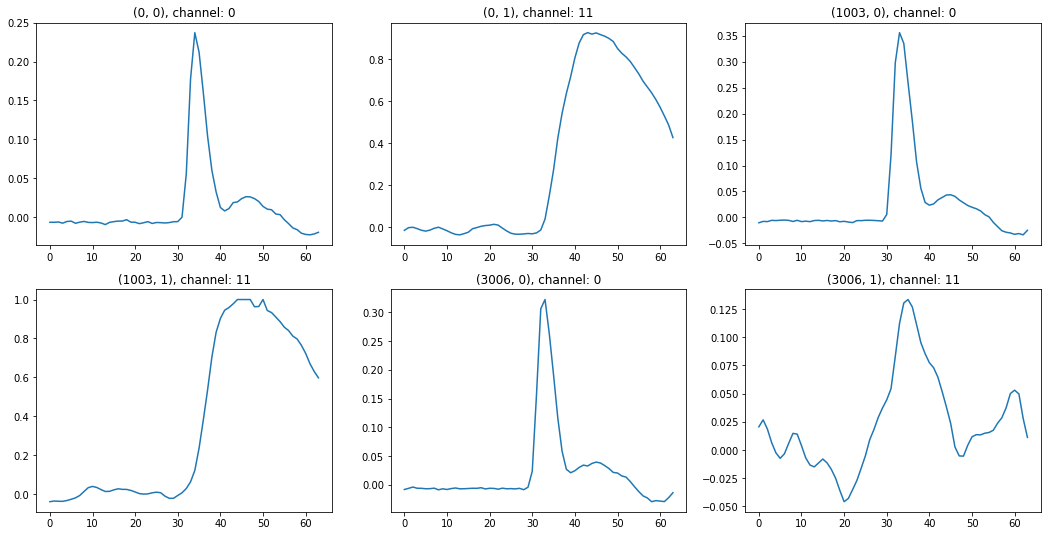

In [14]:
events = [0, 0, 1003, 1003, 3006, 3006]
samples = [0, 1, 0, 1, 0, 1]

plt.figure(figsize=(18, 9))
for i, (i_event, i_sample) in enumerate(zip(events, samples)):
    plt.subplot(2, 3, i + 1)
    plot_sample(new_events[11]['sample_ampl'][i_event][i_sample], title=f"({i_event}, {i_sample}), channel: {new_events[11]['sample_channel'][i_event][i_sample]}")